In [ ]:
import os
import sys
import time
import numpy as np
sys.path.append('./')
import argparse
import itertools
import math
from pathlib import Path
import torch
import json
import torch.nn as nn
import torchvision
# from lion import Lion
import matplotlib.pyplot as plt
from utils import DreamBoothDataset, freeze_parameters, load_unet_for_svdiff, load_text_encoder_for_svdiff, collate_fn, embed_clip
from accelerate.utils import set_seed
from tqdm.auto import tqdm
from diffusers import DiffusionPipeline
from diffusers import DDPMScheduler
import retrieve
import logging
from diffusers.optimization import get_scheduler
import transformers
transformers.utils.logging.set_verbosity_error()

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--instance_data_dir", type=str, default=None)
    parser.add_argument("--class_data_dir", type=str, default=None)
    parser.add_argument("--instance_prompt", type=str, default=None)
    parser.add_argument("--class_prompt", type=str, default=None)
    parser.add_argument("--num_class_images", type=int, default=100)
    parser.add_argument("--output_dir", type=str, default="output")
    parser.add_argument("--seed", type=int, default=None)
    parser.add_argument("--size", type=int, default=512)
    parser.add_argument("--center_crop", default=False, type=bool)
    parser.add_argument("--train_batch_size", type=int, default=4)
    parser.add_argument("--num_train_epochs", type=int, default=1)
    parser.add_argument("--max_train_steps", type=int, default=None)
    parser.add_argument("--save_steps", type=int, default=500)
    parser.add_argument("--gradient_accumulation_steps", type=int, default=1)
    parser.add_argument("--learning_rate", type=float, default=1e-3)
    parser.add_argument("--learning_rate_1d", type=float, default=1e-6)
    parser.add_argument("--scale_lr", default=False, type=bool)
    parser.add_argument("--lr_scheduler", type=str, default="constant")
    parser.add_argument("--lr_warmup_steps", type=int, default=500)
    parser.add_argument("--optim", default="adam", type=bool)
    parser.add_argument("--adam_beta1", type=float, default=0.9)
    parser.add_argument("--adam_beta2", type=float, default=0.999)
    parser.add_argument("--adam_weight_decay", type=float, default=1e-2)
    parser.add_argument("--adam_epsilon", type=float, default=1e-08)
    parser.add_argument("--max_grad_norm", default=1.0, type=float)
    parser.add_argument("--mixed_precision", type=str, default=None, choices=["no", "fp16", "bf16"])
    parser.add_argument("--concepts_list", type=str, default=None)
    parser.add_argument("--modifier_tokens", type=list, default=None)
    parser.add_argument("--initializer_tokens", type=list, default=["pll", "ucd"])
    parser.add_argument("--checkpointing_steps", default=1000, type=int)
    parser.add_argument("--resume_from_checkpoint", default=None, type=bool)
    parser.add_argument("--train_text_encoder", default=False, type=bool)

    args = parser.parse_args(args=[])

    return args

In [3]:
args = parse_args()

run_name = "Fernando-v1"
keyword = "dog"
V_keyword = "<new1>"
instance_prompt = f"a {keyword} {V_keyword}"
regularization_prompt = f"A photo of a dog"
concept_list_json = []
concept_ = {}
concept_["keyword"] = keyword
concept_["identifier"] = V_keyword
concept_["instance_prompt"] = instance_prompt
concept_["class_prompt"] = regularization_prompt
concept_["instance_data_dir"] = f"training_data/{keyword}/"
concept_["class_data_dir"] = f"regularization_data/{keyword}/"
concept_list_json.append(concept_)
with open("concept_list.json", "w") as f:
    json.dump(concept_list_json, f)
modifier_token = [c["identifier"] for c in concept_list_json]

args.run_name = run_name
args.device = "cuda:2"
args.concepts_list = "concept_list.json"
args.size = 1024
args.train_batch_size = 1
args.learning_rate = 1e-3  # 5e-3
args.learning_rate1_d = 1e-5  # 5e-3
args.lr_warmup_steps = 0
args.max_train_steps = 1000
args.num_class_images = 100
args.scale_lr = False
args.modifier_tokens = modifier_token
args.mixed_precision = "bf16"
args.train_text_encoder = True
args.checkpointing_steps = 200
args.output_path = "output"
# args.resume_from_checkpoint = "output/Fernando-test/checkpoint-1400/ckpt.pt"
args.resume_from_checkpoint = False

In [ ]:
def showimages(imgs, rows=False, **kwargs):
    plt.figure(figsize=(kwargs.get("width", 8), kwargs.get("height", 8)))
    plt.axis("off")
    if rows:
        plt.imshow(torch.cat([torch.cat([i for i in row], dim=-1) for row in imgs], dim=-2).permute(1, 2, 0).cpu())
    else:
        plt.imshow(torch.cat([torch.cat([i for i in imgs], dim=-1)], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

dtype = torch.bfloat16
print(f"Starting Finetuning")
device = args.device
if args.seed is not None:
    set_seed(args.seed)

with open(args.concepts_list, "r") as f:
    args.concepts_list = json.load(f)

output_path = os.path.join(args.output_path, args.run_name)
os.makedirs(output_path, exist_ok=True)
json.dump(vars(args), open(os.path.join(output_path, "args.json"), "w"))

print(f"Concept List - {args.concepts_list}")

for i, concept in enumerate(args.concepts_list):
    class_images_dir = Path(concept['class_data_dir'])
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True, exist_ok=True)
    name = '_'.join(concept['class_prompt'].split())
    if not Path(os.path.join(class_images_dir, name)).exists() or len(list(Path(os.path.join(class_images_dir, name)).iterdir())) < args.num_class_images:
        retrieve.retrieve(concept['class_prompt'], class_images_dir, args.num_class_images)
    args.concepts_list[i] = concept

os.makedirs(args.output_dir, exist_ok=True)

s = time.time()

noise_scheduler = DDPMScheduler.from_config("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=dtype, use_safetensors=True, variant="bf16")
# pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-0.9", torch_dtype=torch.float16, use_safetensors=True, variant="fp16").to(args.device)
tokenizer = pipe.tokenizer
tokenizer_pooled = pipe.tokenizer_2
text_encoder = pipe.text_encoder
text_encoder_pooled = pipe.text_encoder_2
unet = pipe.unet
vae = pipe.vae.float()
text_encoder = text_encoder.float()
text_encoder_pooled = text_encoder_pooled.float()
unet = unet.float()
vae.to(device)
unet.to(device)
text_encoder.to(device)
text_encoder_pooled.to(device)
print(f"Model Loading Time: {time.time() - s}")

if args.train_text_encoder:
    learnable_parameters_text, trained_token_embeds = load_text_encoder_for_svdiff(text_encoder, spectral_shifts_ckpt=args.resume_from_checkpoint)
    learnable_parameters_text_pooled, trained_token_embeds_pooled = load_text_encoder_for_svdiff(text_encoder_pooled, spectral_shifts_ckpt=args.resume_from_checkpoint)

s = time.time()
learnable_parameters = load_unet_for_svdiff(unet, spectral_shifts_ckpt=args.resume_from_checkpoint)
if args.train_text_encoder:
    for name, params in learnable_parameters_text.items():
        learnable_parameters[name].extend(params)
    for name, params in learnable_parameters_text_pooled.items():
        learnable_parameters[name].extend(params)

text_encoder.requires_grad_(False).to(dtype)
text_encoder_pooled.requires_grad_(False).to(dtype)
unet.requires_grad_(False).to(dtype)
torch.cuda.empty_cache()

print(f"SVDiff Conversion Time: {time.time() - s}")

total_params = sum(p.numel() for name, params in learnable_parameters.items() for p in params)
print(f"Number of Trainable Parameters: {total_params}")

if args.scale_lr:
    args.learning_rate = (args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size)
    args.learning_rate = args.learning_rate * 2.

# Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
if args.optim == "bitsandbytes":
    import bitsandbytes as bnb
    optimizer_class = bnb.optim.AdamW8bit
elif args.optim == "lion":
    optimizer_class = Lion
else:
    optimizer_class = torch.optim.AdamW
print(f"All models loaded")

# Adding a modifier token which is optimized ####
# Code taken from https://github.com/huggingface/diffusers/blob/main/examples/textual_inversion/textual_inversion.py

def add_modifier_token(args, tokenizer, text_encoder, trained_token_embeds):
    print(f"Modifier Token - {args.modifier_tokens} for Text Encoder object with ID {id(text_encoder)}")
    modifier_token_ids = []
    initializer_token_ids = []
    if len(args.modifier_tokens) > len(args.initializer_tokens):
        raise ValueError("You must specify + separated initializer token for each modifier token.")
    for modifier_token, initializer_token in zip(args.modifier_tokens,
                                                 args.initializer_tokens[:len(args.modifier_tokens)]):
        # Add the placeholder token in tokenizer
        num_added_tokens = tokenizer.add_tokens(modifier_token)
        if num_added_tokens == 0:
            logging.error(
                f"Token '{modifier_token}' already exists in tokenizer. Use a different one.")
            raise ValueError(f"Token '{modifier_token}' already exists in tokenizer. Use a different one.")

        # Convert the initializer_token, placeholder_token to ids
        print(f"Init token: {initializer_token}")
        token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
        print(f"Token IDs - {token_ids}")

        # Check if initializer_token is a single token or a sequence of tokens
        if len(token_ids) > 1:
            logging.error(f"The initializer token must be a single token.")
            raise ValueError("The initializer token must be a single token.")

        initializer_token_ids.append(token_ids[0])
        modifier_token_ids.append(tokenizer.convert_tokens_to_ids(modifier_token))

    # Resize the token embeddings as we are adding new special tokens to the tokenizer
    text_encoder.resize_token_embeddings(len(tokenizer))
    # Initialise the newly added placeholder token with the embeddings of the initializer token
    token_embeds = text_encoder.get_input_embeddings().weight.data
    for modifier_token, modifier_token_id, initializer_token_id in zip(args.modifier_tokens, modifier_token_ids, initializer_token_ids):
        token_embeds[modifier_token_id] = token_embeds[initializer_token_id]
        if trained_token_embeds:
            if modifier_token in trained_token_embeds.keys():
                token_embeds[modifier_token_id] = trained_token_embeds[modifier_token]
                print(f"Loaded {modifier_token_id} token embedding from previous session into Text Encoder with ID {id(text_encoder)}.")

    # Freeze all parameters except for the token embeddings in text encoder
    params_to_freeze = itertools.chain(
        text_encoder.text_model.encoder.parameters(),
        text_encoder.text_model.final_layer_norm.parameters(),
        text_encoder.text_model.embeddings.position_embedding.parameters(),
    )
    freeze_parameters(params_to_freeze)
    return modifier_token_ids

if args.modifier_tokens:
    modifier_token_ids = add_modifier_token(args, tokenizer, text_encoder, trained_token_embeds)
    modifier_token_ids_pooled = add_modifier_token(args, tokenizer_pooled, text_encoder_pooled, trained_token_embeds_pooled)
    
    for params in learnable_parameters.values():
        params.requires_grad_(True)
    
    params_to_optimize = itertools.chain(text_encoder.get_input_embeddings().parameters(), text_encoder_pooled.get_input_embeddings().parameters(),
                                         learnable_parameters["params"])
    print(f"Successfully added all modifier tokens.")
    # print(list(params_to_optimize))
else:
    print(f"Did not receive any modifier tokens, finetuning without.")
    params_to_optimize = (
        itertools.chain(learnable_parameters["params"])
    )

In [ ]:
optimizer = optimizer_class(
    [{"params": params_to_optimize}, {"params": learnable_parameters["params_1d"], "lr": args.learning_rate_1d}],
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

train_dataset = DreamBoothDataset(
    concepts_list=args.concepts_list,
    num_class_images=args.num_class_images,
    size=args.size,
    center_crop=args.center_crop,
)

print(f"Train Dataset & Noise Schedule loaded.")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True,
                                               collate_fn=lambda examples: collate_fn(examples, True), ############################################# CHECK
                                               num_workers=8)

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
    num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
)

if not args.modifier_tokens and not args.train_text_encoder:
    text_encoder.to(dtype=args.mixed_precision)

num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# cache keys to save
state_dict_keys = [k for k in unet.state_dict().keys() if "delta" in k]
if args.train_text_encoder:
    state_dict_keys_te = [k for k in text_encoder.state_dict().keys() if "delta" in k]

def zero_text_encoder_grads(tokenizer, text_encoder, modifier_token_ids):
    grads_text_encoder = text_encoder.get_input_embeddings().weight.grad
    index_grads_to_zero = torch.arange(len(tokenizer)) != modifier_token_ids[0]
    for i in range(len(modifier_token_ids[1:])):
        index_grads_to_zero = index_grads_to_zero | torch.arange(len(tokenizer)) != modifier_token_ids[i]
    grads_text_encoder.data[index_grads_to_zero, :] = grads_text_encoder.data[index_grads_to_zero,:].fill_(0)

def save_weights(step):
    # Create the pipeline using using the trained modules and save it.
    weights = {}
    save_path = os.path.join(output_path, f"checkpoint-{step}")
    os.makedirs(save_path, exist_ok=True)
    state_dict = unet.state_dict()
    state_dict = {k: state_dict[k] for k in state_dict_keys}
    weights["unet"] = state_dict
    if args.train_text_encoder:
        state_dict = text_encoder.state_dict()
        state_dict = {k: state_dict[k] for k in state_dict_keys_te}
        if args.modifier_tokens:
            for i in range(len(modifier_token_ids)):
                token_embed = text_encoder.get_input_embeddings().weight[modifier_token_ids[i]].detach().cpu()
                state_dict[f"modifier_tokens.{args.modifier_tokens[i]}"] = token_embed
                print(f"Saving {args.modifier_tokens[i]} token: {token_embed.shape}.")
        weights["text_encoder"] = state_dict
    torch.save(weights, os.path.join(save_path, "ckpt.pt"))
    print(f"[*] Weights saved at {save_path}")

total_batch_size = args.train_batch_size * args.gradient_accumulation_steps

print("***** Running training *****")
print(f"Num examples = {len(train_dataset)}")
print(f"Num batches each epoch = {len(train_dataloader)}")
print(f"Num Epochs = {args.num_train_epochs}")
print(f"Instantaneous batch size per device = {args.train_batch_size}")
print(f"Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
print(f"Gradient Accumulation steps = {args.gradient_accumulation_steps}")
print(f"Total optimization steps = {args.max_train_steps}")

global_step = 0
first_epoch = 0
resume_step = 0
if args.resume_from_checkpoint:
    path = os.path.basename(args.resume_from_checkpoint)

    if path is None:
        print(f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run.")
        args.resume_from_checkpoint = None
    else:
        # print(f"Resuming from checkpoint {path}")
        # load_state(os.path.join(args.output_dir, path))
        global_step = int(path.split("-")[1])

        resume_global_step = global_step * args.gradient_accumulation_steps
        first_epoch = global_step // num_update_steps_per_epoch
        resume_step = resume_global_step % (num_update_steps_per_epoch * args.gradient_accumulation_steps)

progress_bar = tqdm(range(resume_step, args.max_train_steps))
progress_bar.set_description("Steps")
text_encoder = text_encoder.to(device)

In [ ]:
for epoch in range(first_epoch, args.num_train_epochs):
    print(f"Starting Epoch - {epoch + 1}")
    unet.train()
    if args.modifier_tokens or args.train_text_encoder:
        text_encoder.train()
    for images, captions in train_dataloader:
        images = images.to(device)
        with torch.inference_mode(), torch.no_grad():
            latent_images = vae.config.scaling_factor * vae.encode(images).latent_dist.sample()
        with torch.cuda.amp.autocast(dtype=dtype):
            if np.random.rand() < 0.0:  # 90% of the time, drop the CLIP text embeddings (indepentently)
                clip_captions = [''] * len(captions)  # 5% of the time drop all the captions
            else:
                clip_captions = captions
            clip_text_embeddings, _, clip_text_embeddings_pooled, _ = pipe.encode_prompt(clip_captions, device, num_images_per_prompt=1, do_classifier_free_guidance=1)

        add_time_ids = torch.Tensor([1024., 1024.,    0.,    0., 1024., 1024.]).repeat(images.size(0)).to(device)
        
        noise = torch.randn_like(latent_images)
        timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (latent_images.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latent_images, noise, timesteps)
        added_cond_kwargs = {"text_embeds": clip_text_embeddings_pooled, "time_ids": add_time_ids}
        
        with torch.cuda.amp.autocast(dtype=dtype):
            pred_noise = unet(noisy_latents, timesteps, clip_text_embeddings, added_cond_kwargs=added_cond_kwargs, return_dict=False)[0]
            loss = nn.functional.mse_loss(pred_noise, noise, reduction='none').mean()

        loss.backward()

        # Zero out the gradients for all token embeddings except the newly added
        # embeddings for the concept, as we only want to optimize the concept embeddings
        if args.modifier_tokens:
            zero_text_encoder_grads(tokenizer, text_encoder, modifier_token_ids)
            zero_text_encoder_grads(tokenizer_pooled, text_encoder_pooled, modifier_token_ids_pooled)

        params_to_clip = (itertools.chain(params_to_optimize, learnable_parameters["params_1d"]))
        grad_norm = nn.utils.clip_grad_norm_(params_to_clip, args.max_grad_norm)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        global_step += 1
        if global_step % args.checkpointing_steps == 0:
            save_weights(global_step)
        if global_step % 200 == 0:
            unet.eval()
            text_encoder.eval()
            prompts = ["an illustration of a dog <new1> on the moon", "a beautiful oil painting of dog <new1>", "dog <new1> as a human", "a photo of dog <new1> sitting in a bucket"]

            t = time.time()
            images = pipe(prompt=prompts, num_images_per_prompt=1, output_type="pt")
            print(f"Took {time.time() - t} for sampling {len(prompts)} images")
            print(prompts)
            showimages(images.images)
            unet.train()
            text_encoder.train()

        progress_bar.set_postfix(loss=loss.detach().item(), lr=lr_scheduler.get_last_lr()[0], lr_1d=lr_scheduler.get_last_lr()[1],
                                 grad_norm=grad_norm.item())

save_weights(global_step)
print(f"Finished Training & Saving embeddings")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.16it/s]


Took 25.086318969726562 for sampling 4 images
A beautiful painting <new1> of a dog


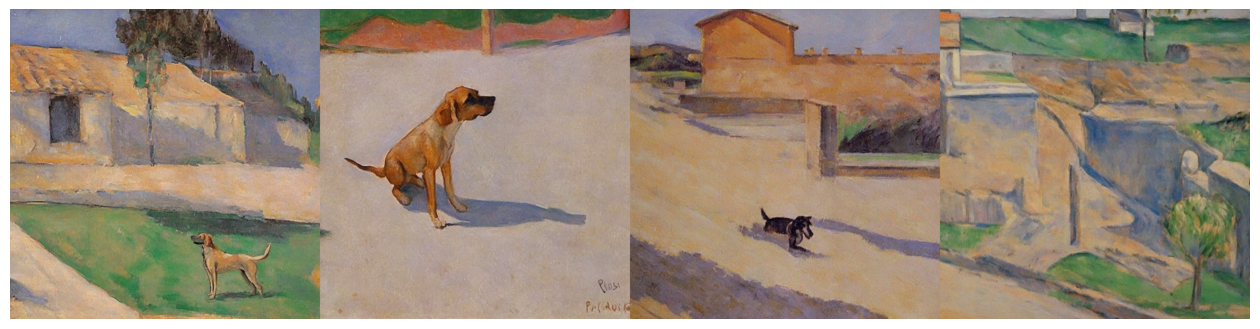

In [10]:
num_images_per_prompt = 4
prompt = "A beautiful painting <new1> of a dog"
t = time.time()
images = pipe(prompt=prompt, num_images_per_prompt=num_images_per_prompt, output_type="pt")
print(f"Took {time.time() - t} for sampling {num_images_per_prompt} images")
print(prompt)
showimages(images.images, height=16, width=16)